In [406]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [407]:
labelled_df = pd.read_csv("../data/external/os_kernel_power_dataset.csv")
labelled_df.head()

,Timestamp,Syscall,PID,Process_Name,Power_W,CPU_Usage_%,Mem_Usage_MB,Label
0,2025-05-05 10:00:00,read,1013,pm_monitor,4.17,85.53,393.18,Normal
1,2025-05-05 10:00:01,open,1067,kernel_thread,7.60,41.54,275.17,Normal
2,2025-05-05 10:00:02,open,1038,powerd,8.99,26.97,306.22,Anomaly
3,2025-05-05 10:00:03,read,1020,powerd,5.36,78.62,218.00,Normal
4,2025-05-05 10:00:04,ioctl,1056,powerd,6.43,38.44,301.01,Normal


In [408]:
label_encoder = LabelEncoder()
labelled_df["Label"] = label_encoder.fit_transform(labelled_df["Label"])

labelled_df["Timestamp"] = pd.to_datetime(labelled_df["Timestamp"])
labelled_df["Timestamp"] = labelled_df["Timestamp"].astype("int64") // 10**9

#        SEPARATE FEATURES & TARGET

In [409]:

X = labelled_df.drop(["Label", "PID", "Process_Name"], axis=1)
y = labelled_df["Label"]
print(X)
print(y)

      Timestamp Syscall  Power_W  CPU_Usage_%  Mem_Usage_MB
0    1746439200    read     4.17        85.53        393.18
1    1746439201    open     7.60        41.54        275.17
2    1746439202    open     8.99        26.97        306.22
3    1746439203    read     5.36        78.62        218.00
4    1746439204   ioctl     6.43        38.44        301.01
..          ...     ...      ...          ...           ...
995  1746440195    open     4.27        16.35        280.59
996  1746440196   write     5.62         7.75        216.82
997  1746440197    mmap     5.30        47.76        135.26
998  1746440198   write     6.09        44.30         32.62
999  1746440199    open     5.55        54.48        390.25

[1000 rows x 5 columns]
0      1
1      1
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Label, Length: 1000, dtype: int64


In [410]:
num_cols = ["Power_W", "CPU_Usage_%", "Mem_Usage_MB", "Timestamp"]
cat_cols = ["Syscall"]

#            TRAIN-TEST SPLIT


In [411]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

# Column Transfromer

In [412]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ],
    remainder="drop"
)

# ===========================================
#         XGBOOST PIPELINE
# ===========================================

In [413]:
xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric="logloss"
    ))
])

In [414]:
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# PREDICTION & METRICS


In [415]:
y_pred = xgb_pipeline.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.9633333333333334

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        24
           1       0.97      0.99      0.98       276

    accuracy                           0.96       300
   macro avg       0.91      0.83      0.86       300
weighted avg       0.96      0.96      0.96       300



Confusion Matrix:


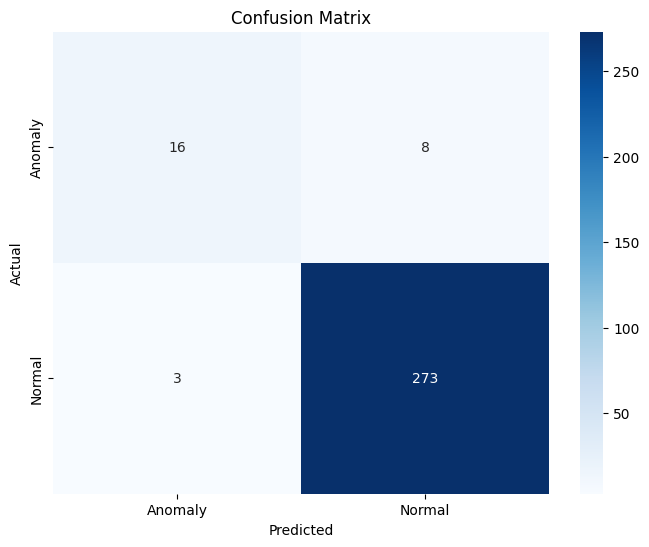

In [416]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#       FEATURE IMPORTANCE (XGBOOST)


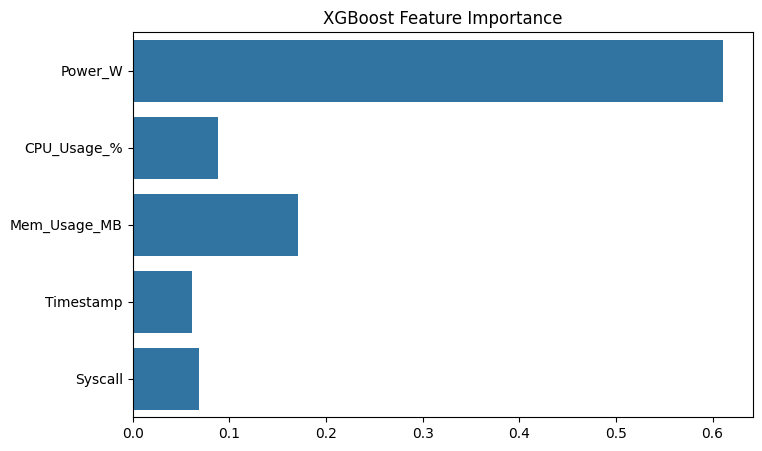

In [417]:
model = xgb_pipeline.named_steps["model"]

plt.figure(figsize=(8,5))
sns.barplot(x=model.feature_importances_,
            y=num_cols + cat_cols)
plt.title("XGBoost Feature Importance")
plt.show()

In [418]:
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print(f"\nXGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"XGBoost F1 Score: {f1_score(y_test, y_pred):.4f}")


XGBoost Accuracy: 0.9633
XGBoost F1 Score: 0.9803


# ===========================================
# Random Forest Pipeline
# ===========================================

In [419]:
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=3,
        random_state=32
    ))
])

rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# PREDICTION & METRICS

In [420]:
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9666666666666667

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        24
           1       0.97      1.00      0.98       276

    accuracy                           0.97       300
   macro avg       0.98      0.79      0.86       300
weighted avg       0.97      0.97      0.96       300



Confusion Matrix:


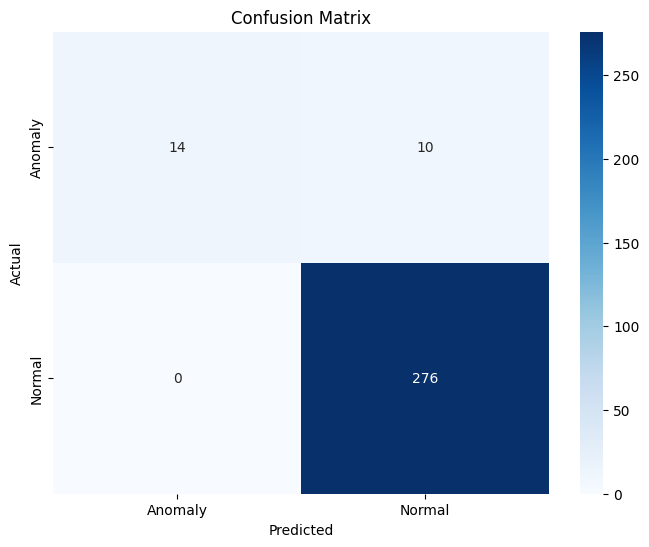

In [421]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#      FEATURE IMPORTANCE (RANDOM FOREST)


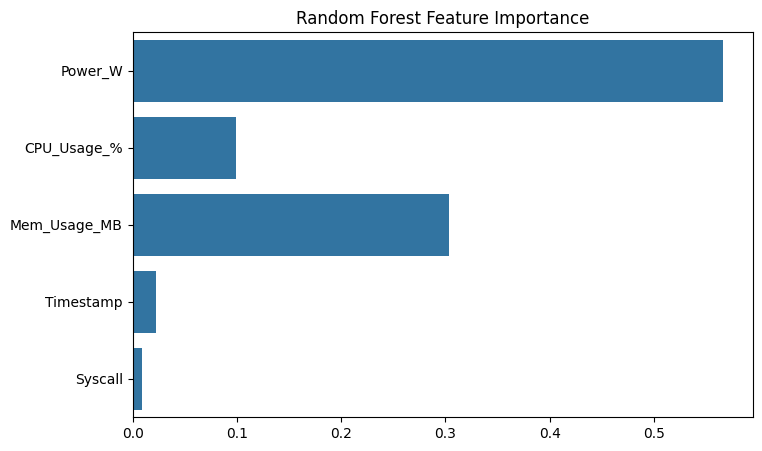

In [422]:

rf_model = rf_pipeline.named_steps["model"]

plt.figure(figsize=(8,5))
sns.barplot(x=rf_model.feature_importances_,
            y=num_cols + cat_cols)
plt.title("Random Forest Feature Importance")
plt.show()

In [424]:
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(f"\nRandom Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred_rf):.4f}")


Random Forest Accuracy: 0.9667
Random Forest F1 Score: 0.9822


# -----------------------------
# Supervised Fusion: Soft Voting
# -----------------------------

In [426]:

# Average probabilities from both models
supervised_prob = (y_prob_xgb + y_prob_rf) / 2
supervised_pred = (supervised_prob >= 0.5). astype(int)

print(f"\nSupervised Ensemble (Voting) Accuracy: {accuracy_score(y_test, supervised_pred):.4f}")
print(f"Supervised Ensemble (Voting) F1 Score: {f1_score(y_test, supervised_pred):.4f}")


Supervised Ensemble (Voting) Accuracy: 0.9667
Supervised Ensemble (Voting) F1 Score: 0.9821
